In [1]:
import torch

In [2]:
# 注册wandb
import wandb
wandb.login()


wandb: Currently logged in as: 769997102 (769997102-southern-university-of-science-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
import os,PIL 
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch 
from torch import nn 
import torchvision 
from torchvision import transforms
import datetime
import wandb 
from argparse import Namespace

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = Namespace(
    project_name = 'wandb_demo',
    
    batch_size = 512,
    
    hidden_layer_width = 64,
    dropout_p = 0.1,
    
    lr = 1e-4,
    optim_type = 'Adam',
    
    epochs = 15,
    ckpt_path = 'checkpoint.pt'
)

In [4]:
def create_dataloaders(config):
    transform = transforms.Compose([transforms.ToTensor()])
    ds_train = torchvision.datasets.MNIST(root="./mnist/",train=True,download=True,transform=transform)
    ds_val = torchvision.datasets.MNIST(root="./mnist/",train=False,download=True,transform=transform)

    ds_train_sub = torch.utils.data.Subset(ds_train, indices=range(0, len(ds_train), 5))
    dl_train =  torch.utils.data.DataLoader(ds_train_sub, batch_size=config.batch_size, shuffle=True,
                                            num_workers=2,drop_last=True)
    dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=config.batch_size, shuffle=False, 
                                          num_workers=2,drop_last=True)
    return dl_train,dl_val

In [5]:
def create_net(config):
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=config.hidden_layer_width,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2)) 
    net.add_module("conv2",nn.Conv2d(in_channels=config.hidden_layer_width,
                                     out_channels=config.hidden_layer_width,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = config.dropout_p))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(config.hidden_layer_width,config.hidden_layer_width))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(config.hidden_layer_width,10))
    net.to(device)
    return net 

In [6]:
def train_epoch(model,dl_train,optimizer):
    model.train()
    for step, batch in enumerate(dl_train):
        features,labels = batch
        features,labels = features.to(device),labels.to(device)

        preds = model(features)
        loss = nn.CrossEntropyLoss()(preds,labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    return model

In [7]:
def eval_epoch(model,dl_val):
    model.eval()
    accurate = 0
    num_elems = 0
    for batch in dl_val:
        features,labels = batch
        features,labels = features.to(device),labels.to(device)
        with torch.no_grad():
            preds = model(features)
        predictions = preds.argmax(dim=-1)
        accurate_preds =  (predictions==labels)
        num_elems += accurate_preds.shape[0]
        accurate += accurate_preds.long().sum()

    val_acc = accurate.item() / num_elems
    return val_acc

In [8]:
def train(config = config):
    dl_train, dl_val = create_dataloaders(config)
    model = create_net(config); 
    optimizer = torch.optim.__dict__[config.optim_type](params=model.parameters(), lr=config.lr)
    #======================================================================
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    wandb.init(project=config.project_name, config = config.__dict__, name = nowtime, save_code=True)
    model.run_id = wandb.run.id
    #======================================================================
    model.best_metric = -1.0
    for epoch in range(1,config.epochs+1):
        model = train_epoch(model,dl_train,optimizer)
        val_acc = eval_epoch(model,dl_val)
        if val_acc>model.best_metric:
            model.best_metric = val_acc
            torch.save(model.state_dict(),config.ckpt_path)   
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"epoch【{epoch}】@{nowtime} --> val_acc= {100 * val_acc:.2f}%")
        #======================================================================
        wandb.log({'epoch':epoch, 'val_acc': val_acc, 'best_val_acc':model.best_metric})
        #======================================================================        
    #======================================================================
    wandb.finish()
    #======================================================================
    return model   

In [9]:
model = train(config) ##3,2,1 点火🔥🔥


epoch【1】@2025-10-16 23:17:36 --> val_acc= 41.60%
epoch【2】@2025-10-16 23:17:37 --> val_acc= 50.00%
epoch【3】@2025-10-16 23:17:37 --> val_acc= 61.43%
epoch【4】@2025-10-16 23:17:38 --> val_acc= 68.46%
epoch【5】@2025-10-16 23:17:38 --> val_acc= 70.07%
epoch【6】@2025-10-16 23:17:39 --> val_acc= 76.63%
epoch【7】@2025-10-16 23:17:39 --> val_acc= 79.21%
epoch【8】@2025-10-16 23:17:40 --> val_acc= 82.74%
epoch【9】@2025-10-16 23:17:40 --> val_acc= 84.82%
epoch【10】@2025-10-16 23:17:41 --> val_acc= 86.28%
epoch【11】@2025-10-16 23:17:41 --> val_acc= 87.04%
epoch【12】@2025-10-16 23:17:42 --> val_acc= 87.91%
epoch【13】@2025-10-16 23:17:42 --> val_acc= 88.66%
epoch【14】@2025-10-16 23:17:42 --> val_acc= 89.70%


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch【15】@2025-10-16 23:17:43 --> val_acc= 90.31%


best_val_acc,▁▂▄▅▅▆▆▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
val_acc,▁▂▄▅▅▆▆▇▇▇█████
best_val_acc,0.90306
epoch,15
val_acc,0.90306


In [12]:
!nvidia-smi

Thu Oct 16 23:17:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0  On |                  Off |
| 60%   71C    P0            290W /  450W |   20446MiB /  24564MiB |     95%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

ModuleNotFoundError: No module named 'w'

In [13]:
#resume the run 
import wandb 

run = wandb.init(project='wandb_demo', id= model.run_id, resume='must')

In [14]:
# save dataset 
arti_dataset = wandb.Artifact('mnist', type='dataset')
arti_dataset.add_dir('mnist/')
wandb.log_artifact(arti_dataset)

wandb: Adding directory to artifact (mnist)... Done. 0.1s


<Artifact mnist>

In [15]:
# save code 

arti_code = wandb.Artifact('ipynb', type='code')
arti_code.add_file('./wandb.ipynb')
wandb.log_artifact(arti_code)

<Artifact ipynb>

In [16]:
# save model

arti_model = wandb.Artifact('cnn', type='model')
arti_model.add_file(config.ckpt_path)
wandb.log_artifact(arti_model)

<Artifact cnn>

In [17]:
wandb.finish() #finish时会提交保存


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,0.90306
epoch,15
val_acc,0.90306


In [18]:
#resume the run 
import wandb 
run = wandb.init(project=config.project_name, id= model.run_id, resume='must')

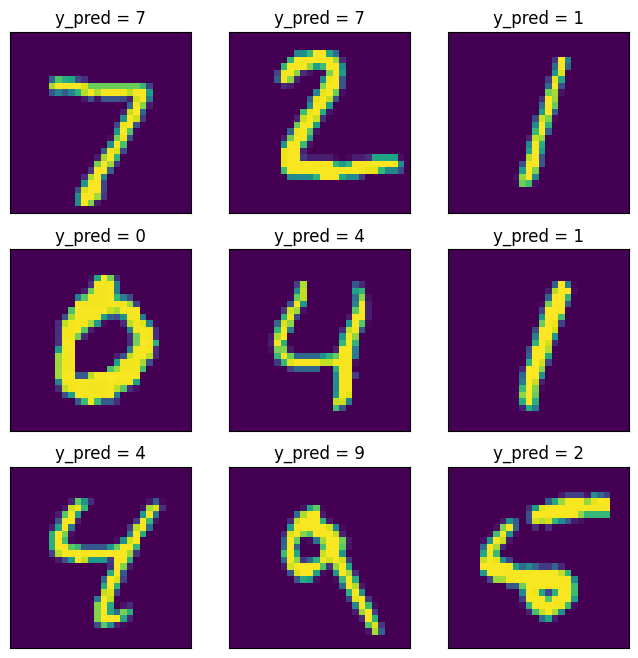

In [19]:
import matplotlib.pyplot as plt 

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="./mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="./mnist/",train=False,download=True,transform=transform)
    
# visual the  prediction
device = None
for p in model.parameters():
    device = p.device
    break

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_val[i]
    tensor = img.to(device)
    y_pred = torch.argmax(model(tensor[None,...])) 
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("y_pred = %d"%y_pred)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()    

In [20]:
def data2fig(data):
    import matplotlib.pyplot as plt 
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(data)
    ax.set_xticks([])
    ax.set_yticks([]) 
    return fig

def fig2img(fig):
    import io,PIL
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

In [21]:
from tqdm import tqdm 
good_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])
bad_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])

  2%|▏         | 20/1000 [00:00<00:21, 46.18it/s]/tmp/ipykernel_1004813/3920330832.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()
100%|██████████| 1000/1000 [00:04<00:00, 222.32it/s]


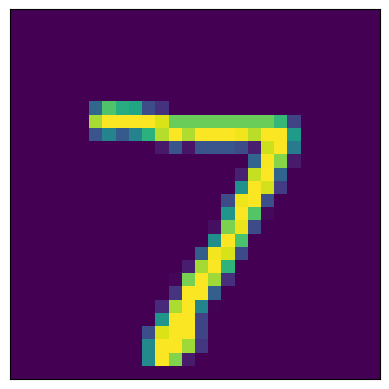

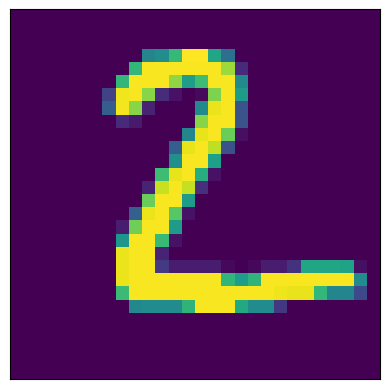

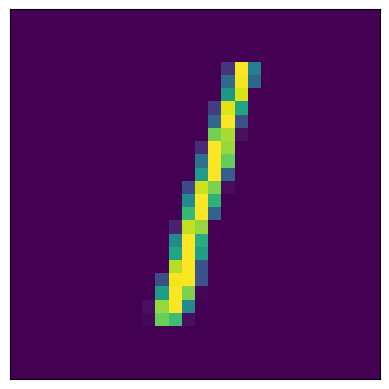

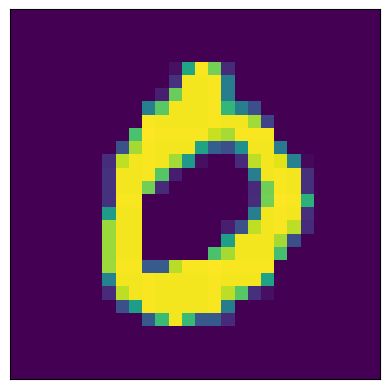

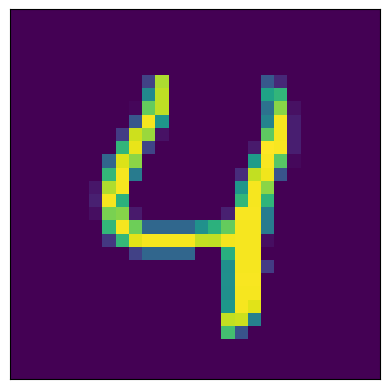

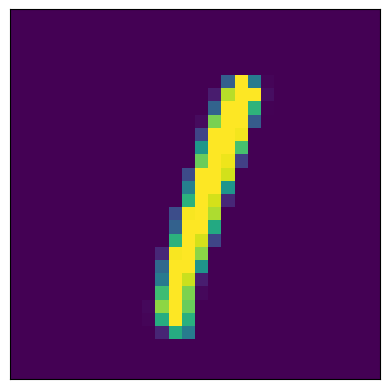

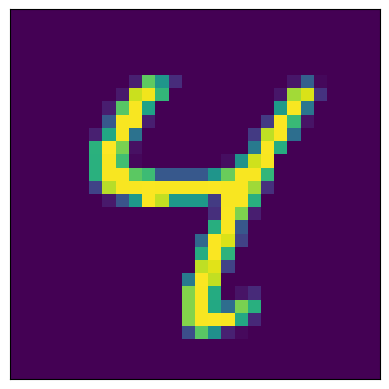

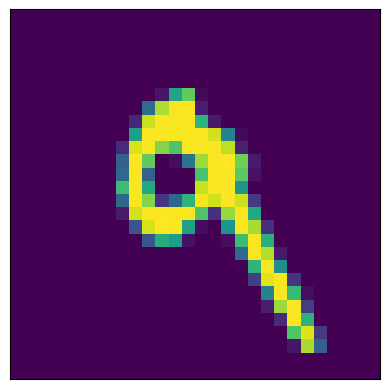

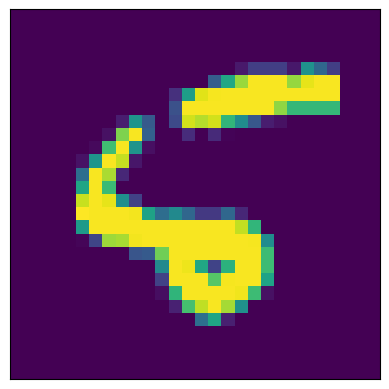

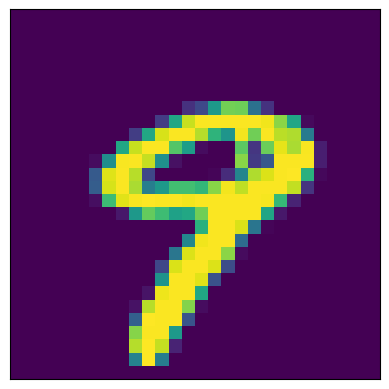

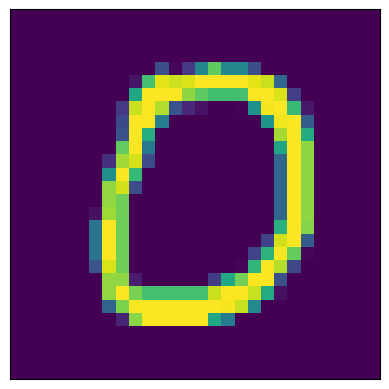

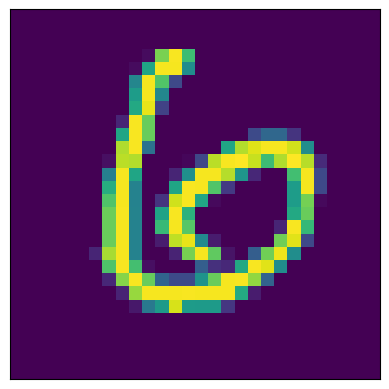

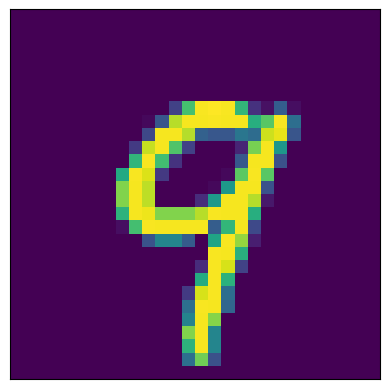

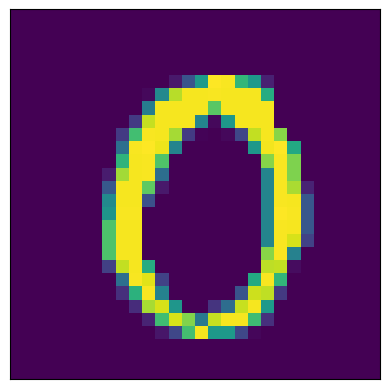

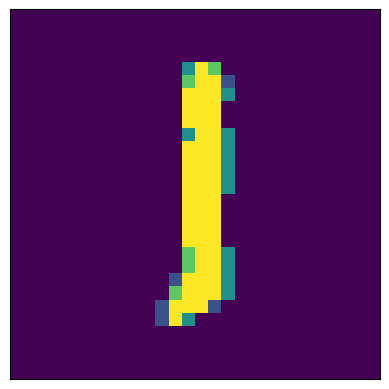

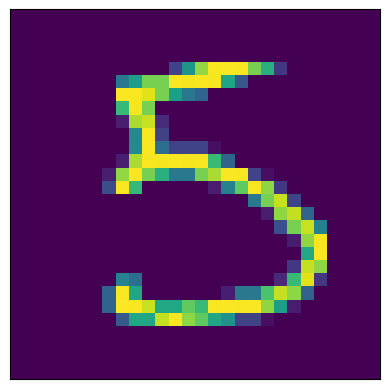

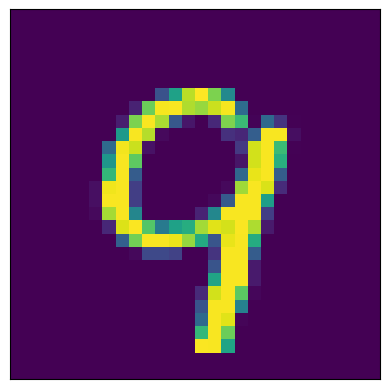

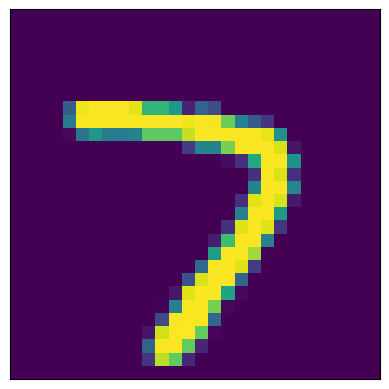

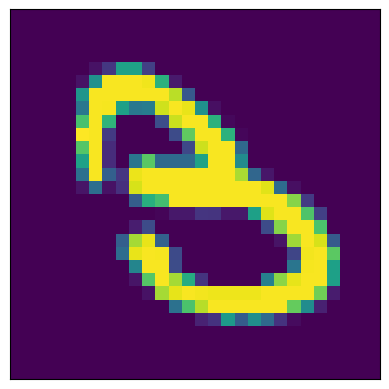

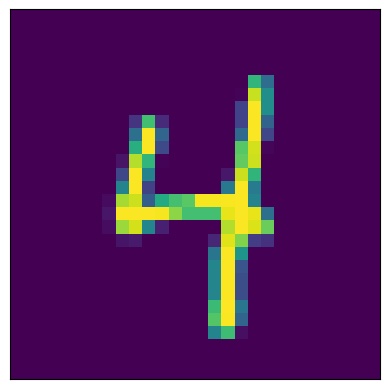

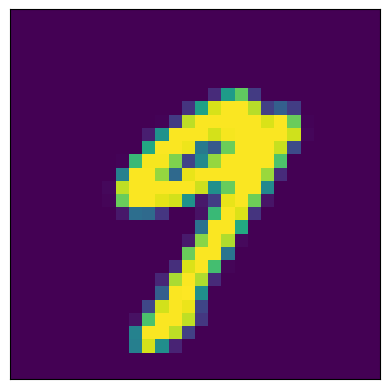

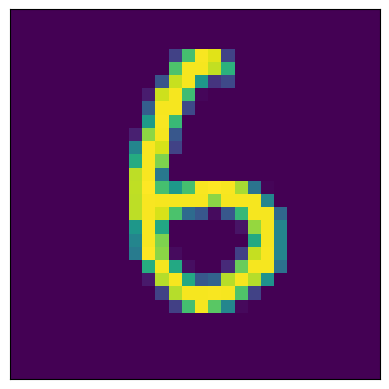

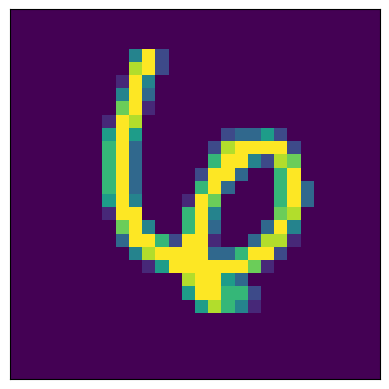

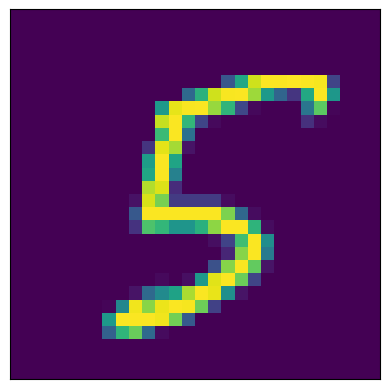

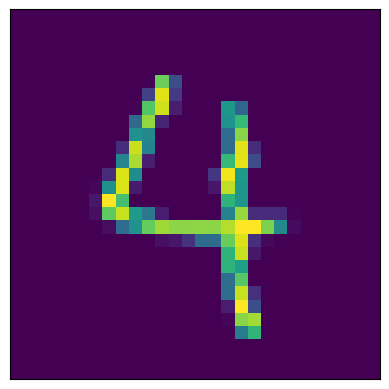

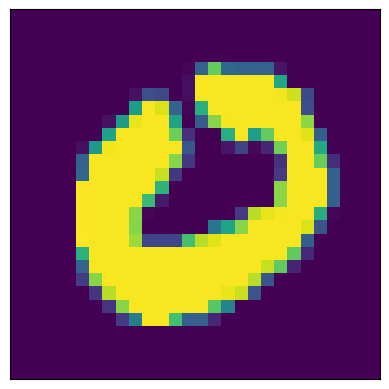

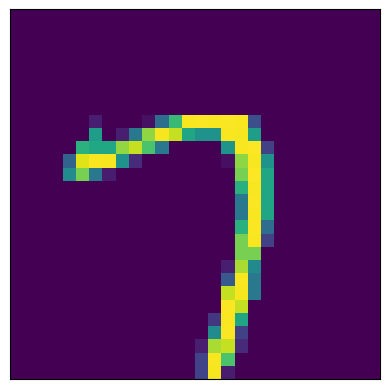

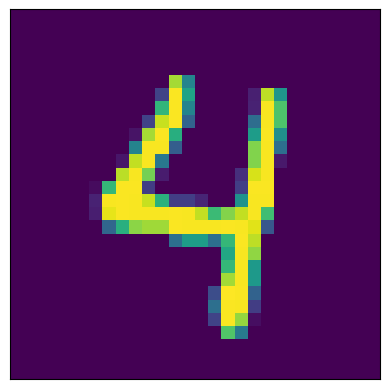

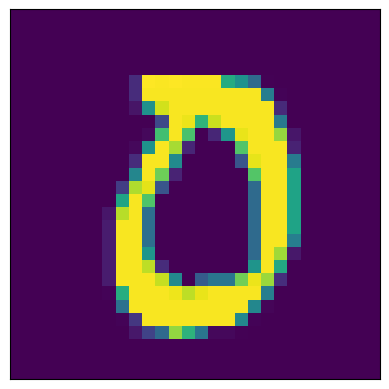

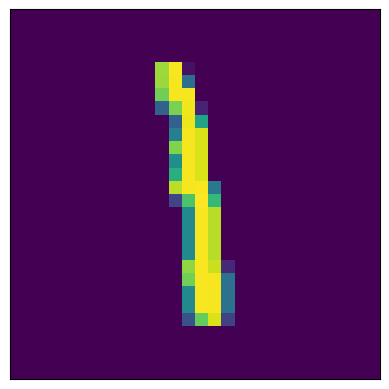

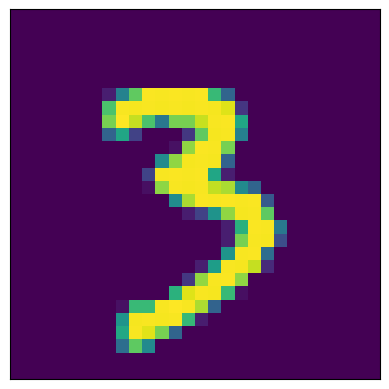

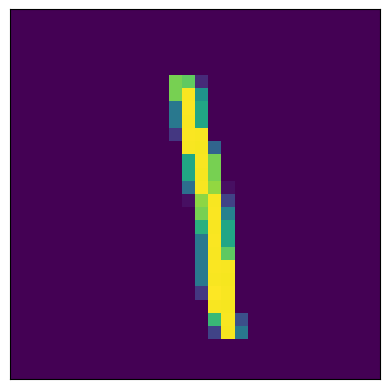

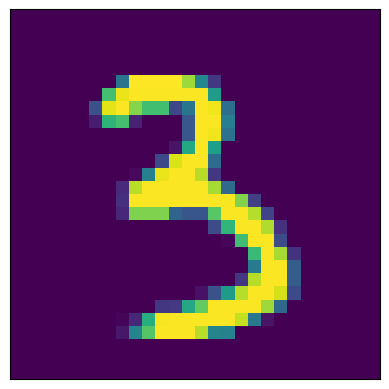

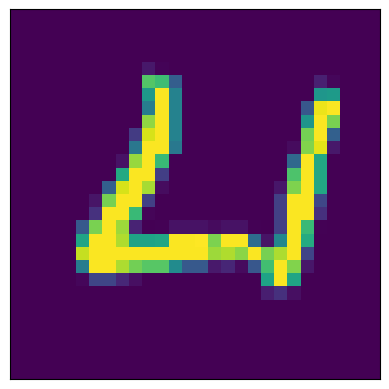

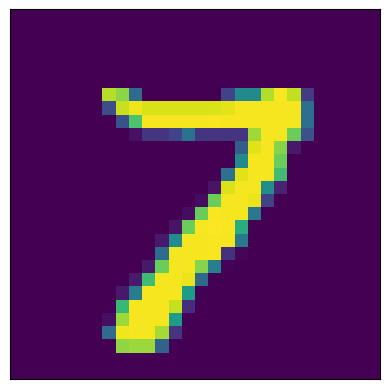

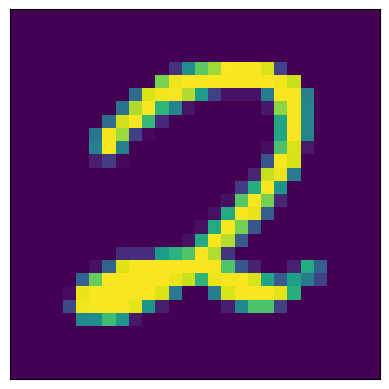

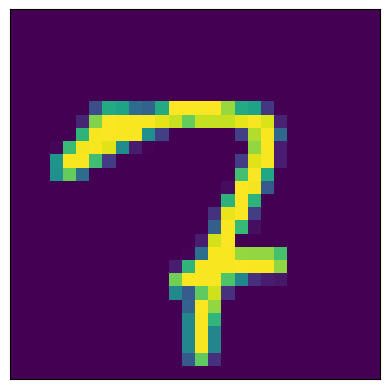

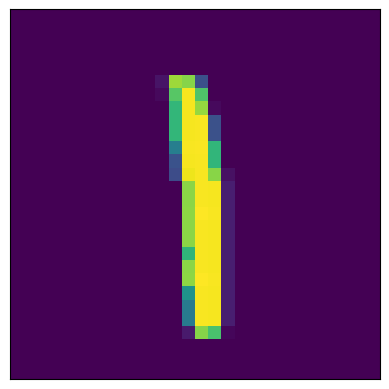

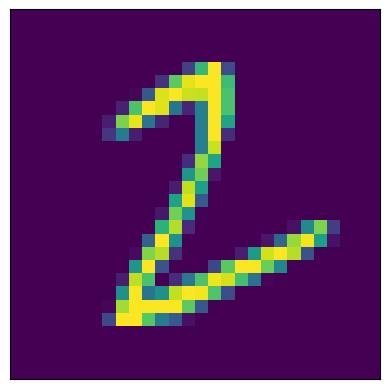

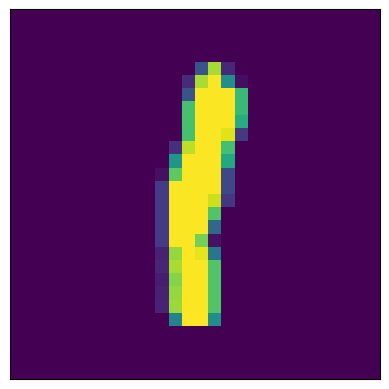

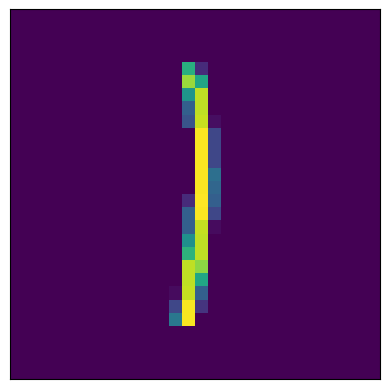

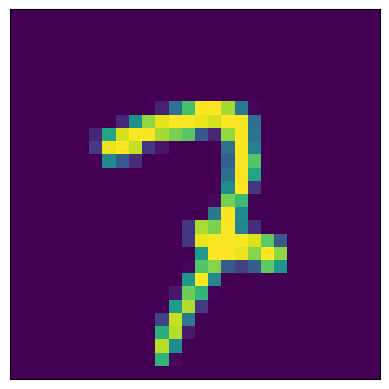

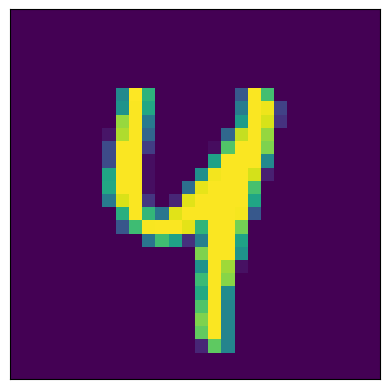

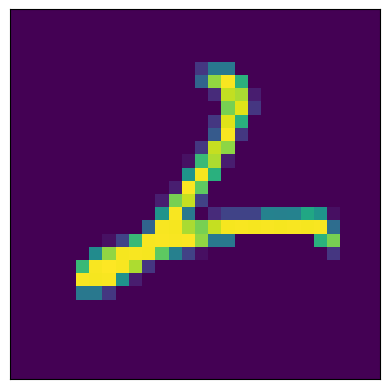

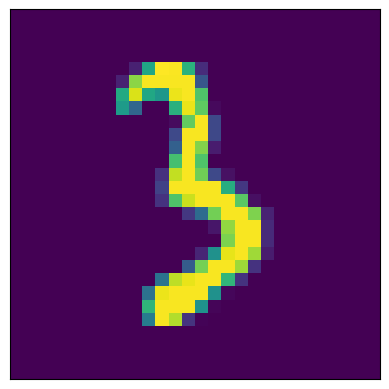

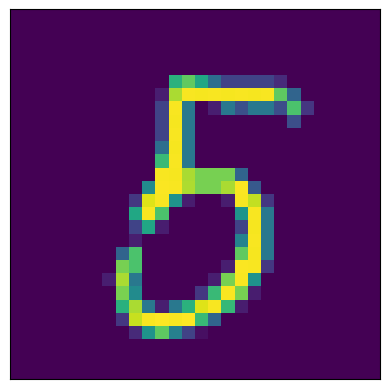

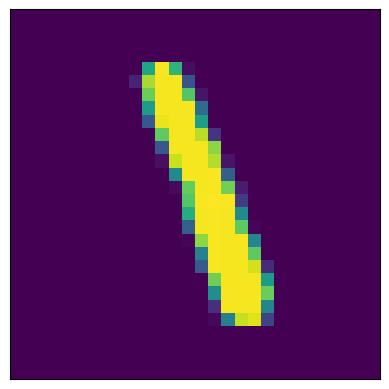

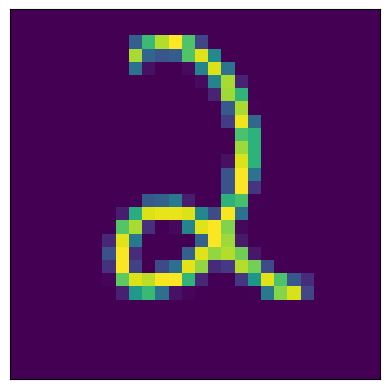

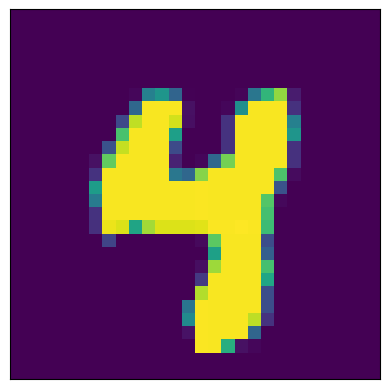

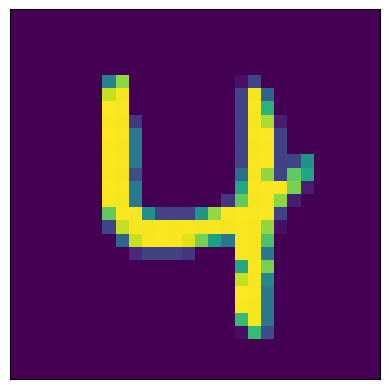

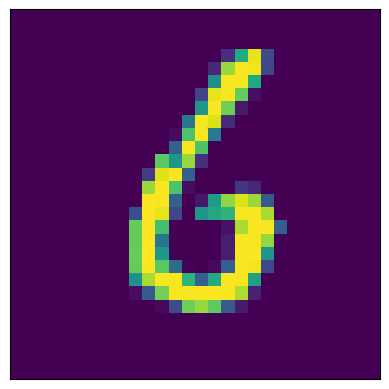

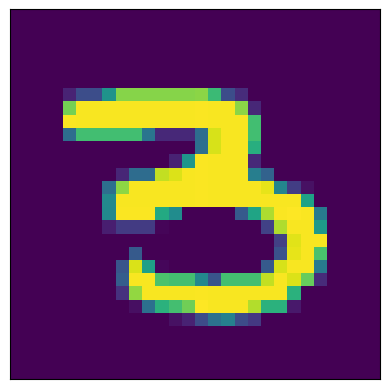

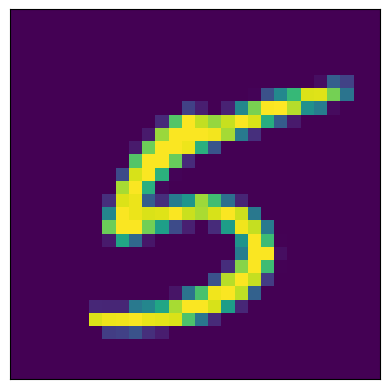

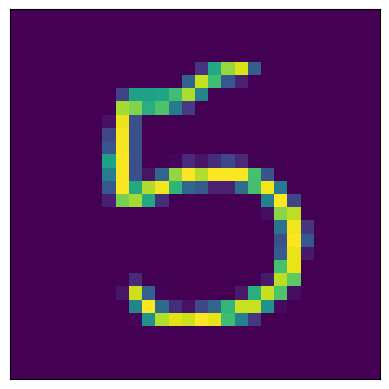

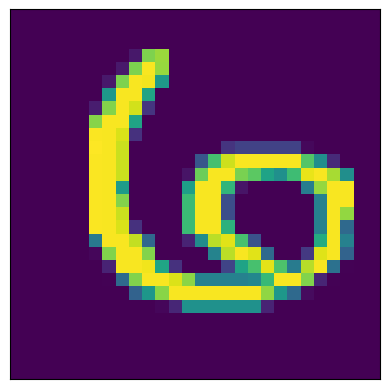

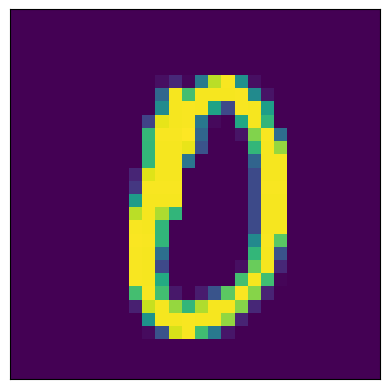

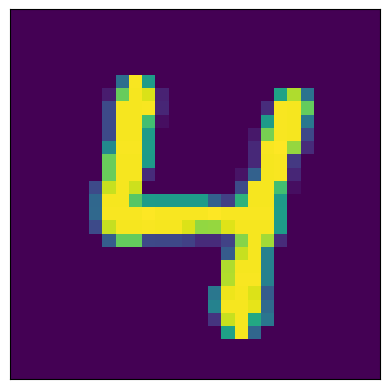

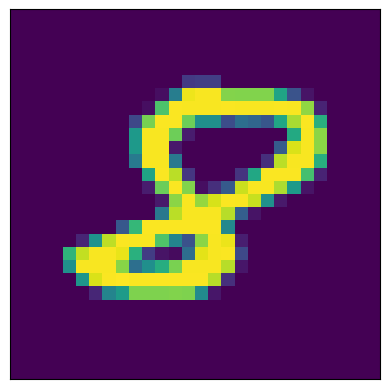

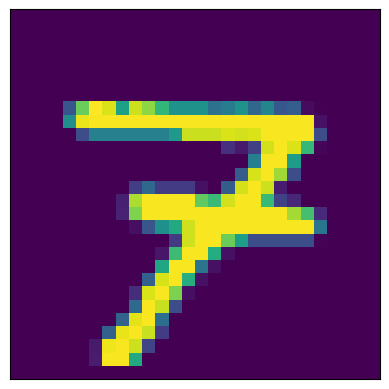

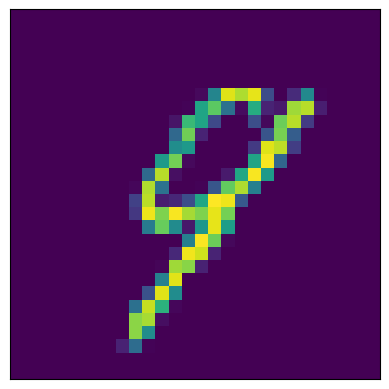

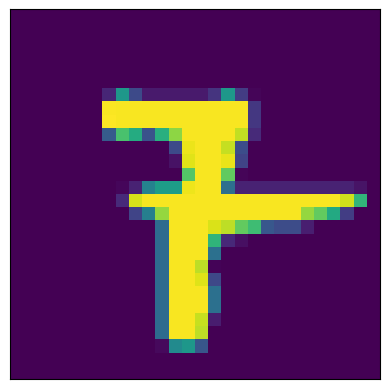

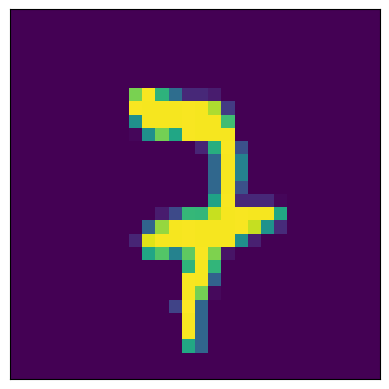

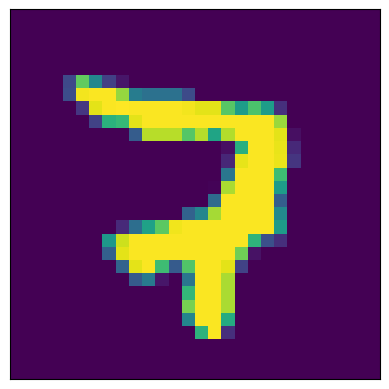

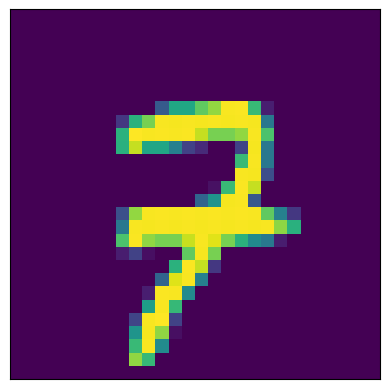

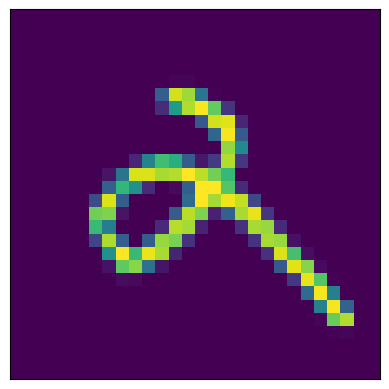

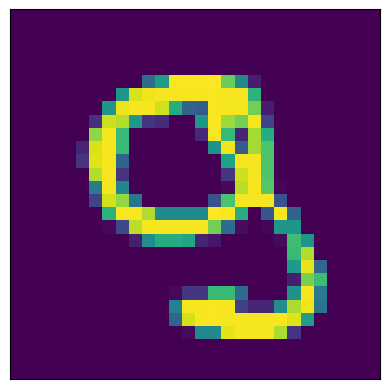

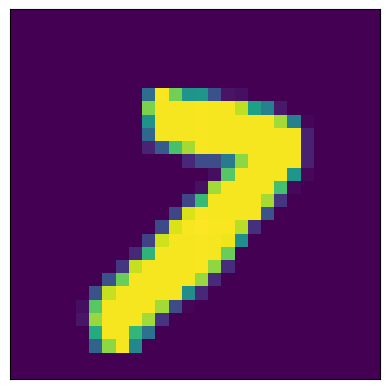

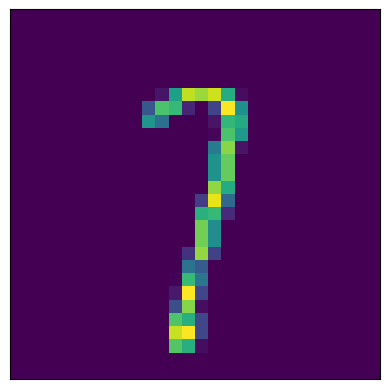

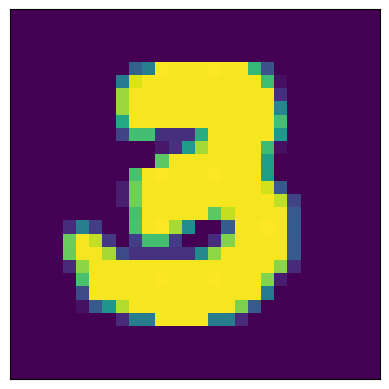

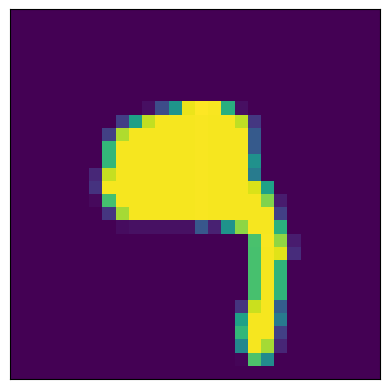

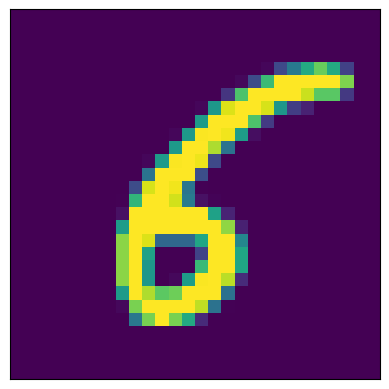

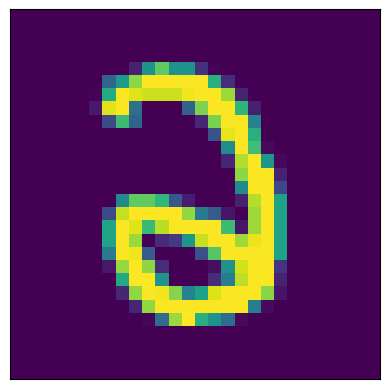

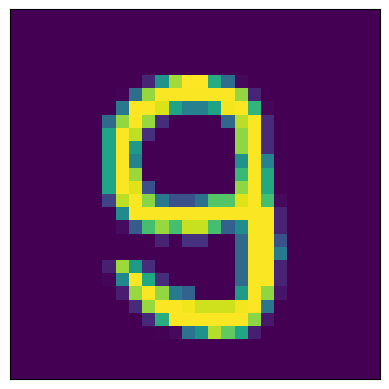

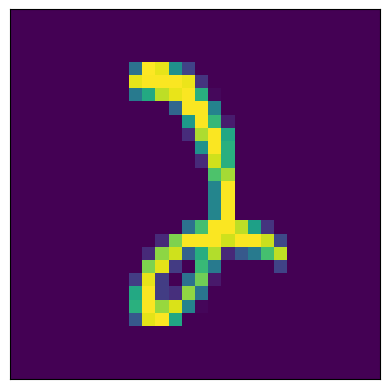

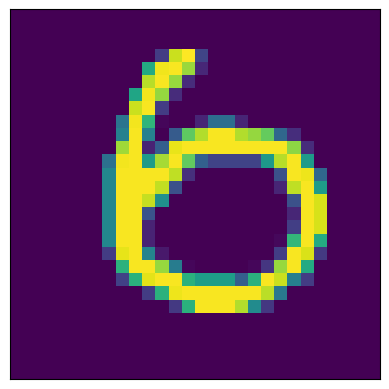

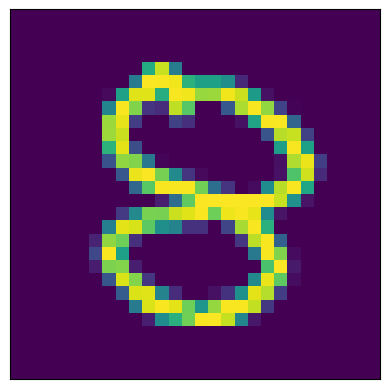

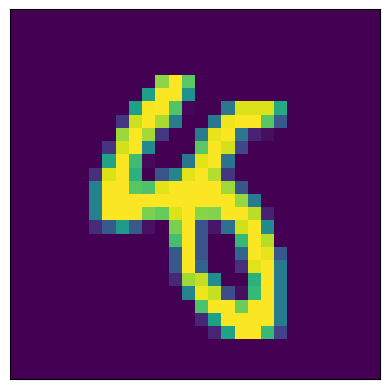

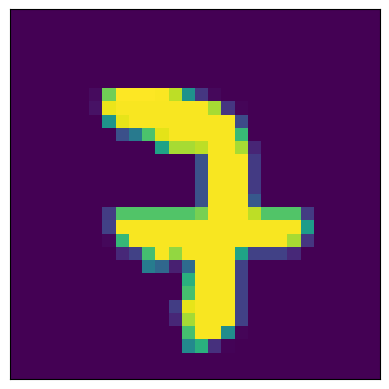

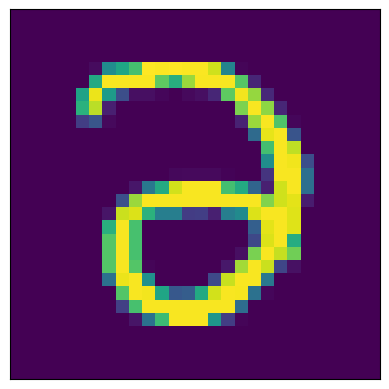

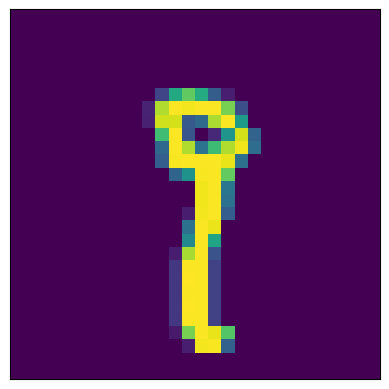

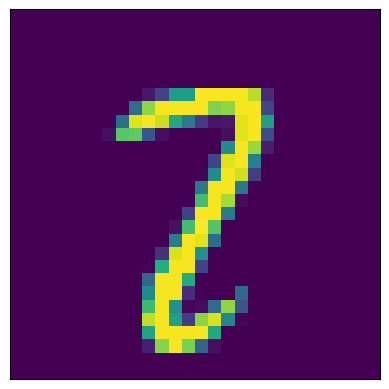

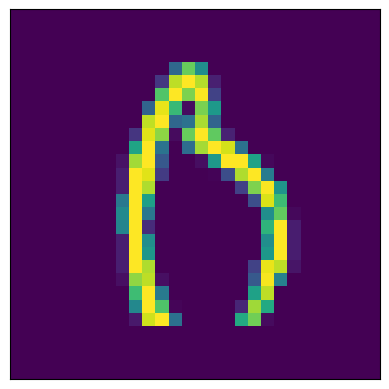

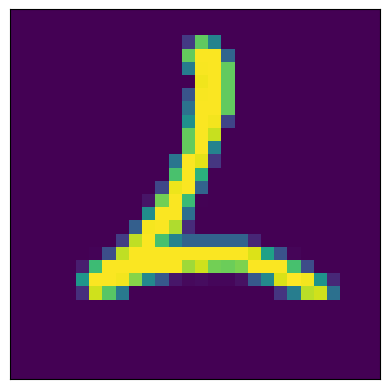

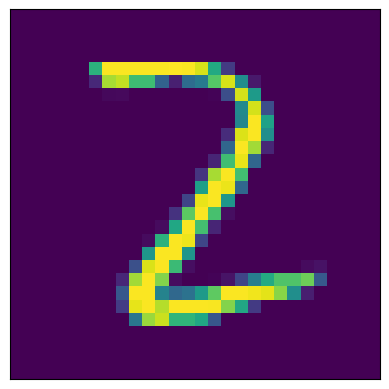

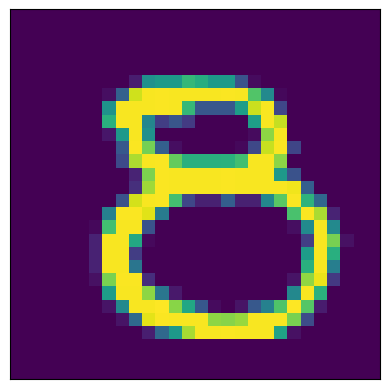

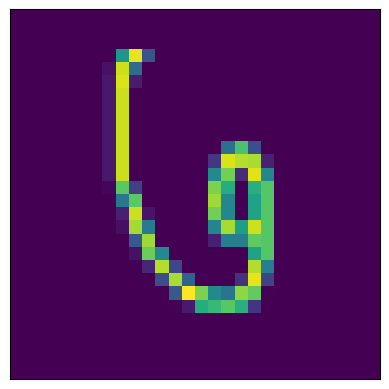

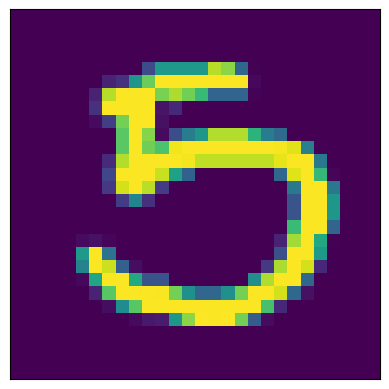

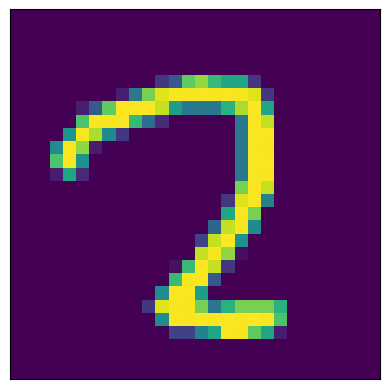

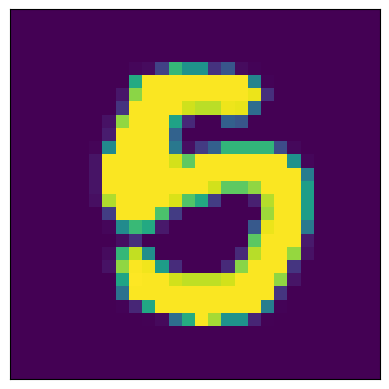

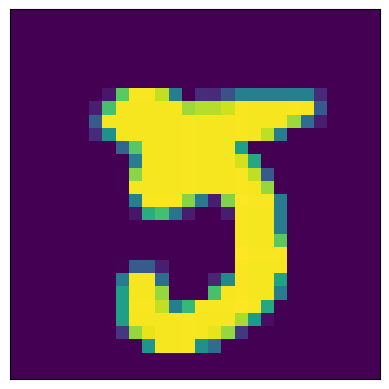

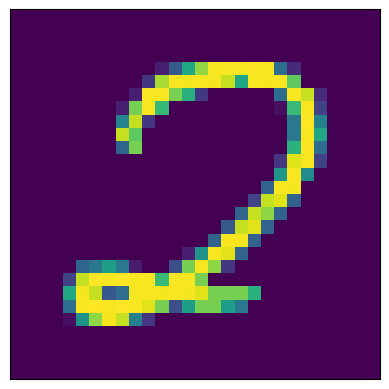

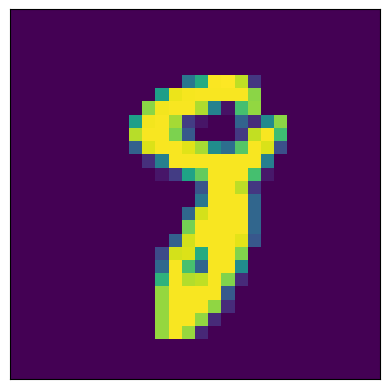

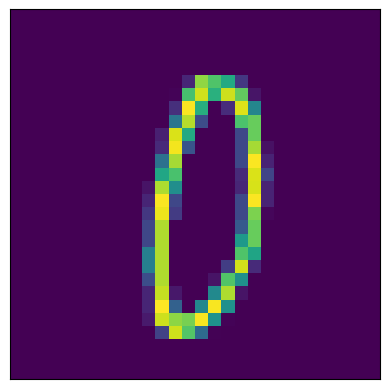

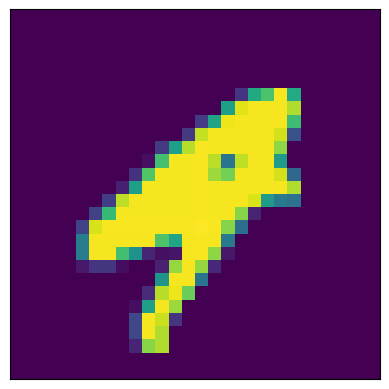

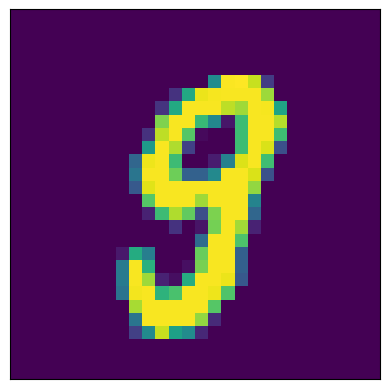

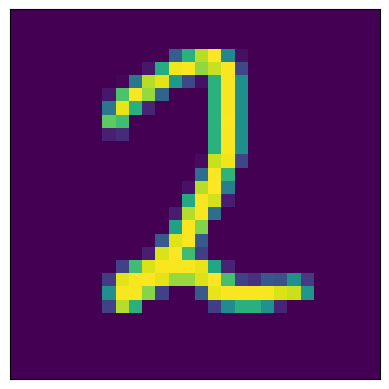

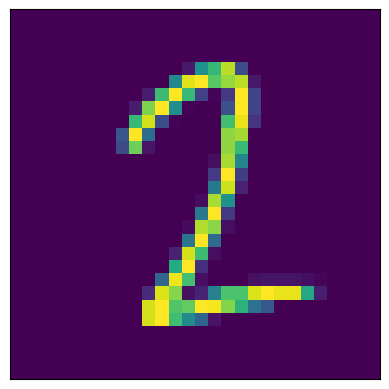

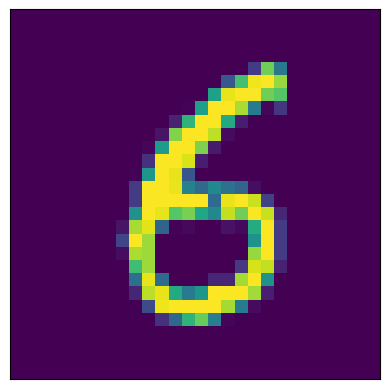

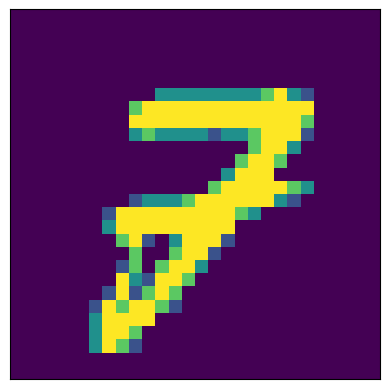

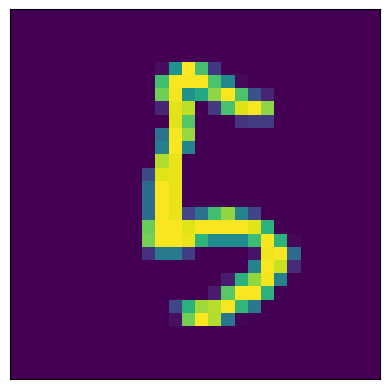

In [22]:
# 找到50个good cases 和 50 个bad cases

plt.close()

for i in tqdm(range(1000)):
    features,label = ds_val[i]
    tensor = features.to(device)
    y_pred = torch.argmax(model(tensor[None,...])) 
    
    # log badcase
    if y_pred!=label:
        if len(bad_cases.data)<50:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            bad_cases.add_data(input_img,label,y_pred)
            
    # log goodcase
    else:
        if len(good_cases.data)<50:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            good_cases.add_data(input_img,label,y_pred)

In [23]:
wandb.log({'good_cases':good_cases,'bad_cases':bad_cases})


In [24]:
wandb.finish()


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_acc,0.90306
epoch,15
val_acc,0.90306
